First, a bit of a hack in case your IDE wants to run the notebook from `/material/` and not the project root folder `/ma1`. We need the working directory to be `/ma1` for local imports to work.

In [ ]:
import os
from pathlib import Path

# Ensure the working directory is set to the "ma1" folder.
while Path.cwd().name != "ma1" and "ma1" in str(Path.cwd()):
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

***

# Neural Networks in PyTorch

Traditional machine learning methods, like logistic regression, are often sufficient for datasets that are linearly separable. However, more complex problems, such as image recognition and natural language understanding/processing (NLU/P), sometimes demand a more intricate approach. Neural networks, which incorporate additional layers, excel at learning non-linear relationships. These extra layers, known as *hidden* layers, process the input into one or more intermediate forms before generating the final prediction.

Logistic regression achieves this transformation using a single fully-connected layer. We can think of this as a Single-Layer Perceptron (although, please don't call it that). This layer performs a linear transformation (a matrix multiplication combined with a bias). In contrast, a neural network with multiple connected layers is typically referred to as a Multi-Layer Perceptron (MLP). For instance, in the simple MLP shown below, a 4-dimensional input is mapped to a 5-dimensional hidden representation, which is subsequently transformed into a single output used for prediction. This is a "simple" architecture: A so-called artificial neural network. 

<img src="../media/MLP.png" width="500"/>


#### Nonlinearities revisited

Nonlinearities are usually applied between the layers of a neural network. As discussed in class 2, there are several reasons for this. A key reason is that without any nonlinearity, a sequence of linear transformations (fully connected layers) reduces to a single linear transformation, limiting the model's expressiveness to that of a single layer. Including nonlinearities between layers prevents this reduction, enabling neural networks to approximate far more complex functions. This is what makes neural networks so powerful.

Numerous nonlinear activation functions are frequently employed in neural networks, but one of the most commonly used is the [rectified linear unit (ReLU)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)):

```math
\begin{align}
x = \max(0,x)
\end{align}
```

#### Why neural networks?
The real power of neural networks lies in their ability to deal with problems that aren’t simple. A lot of traditional methods, like logistic regression, are limited to drawing straight lines (linear decision boundaries) to separate data. That works well if your data happens to fall neatly into two groups, like the example on the left below. But in real life, things are rarely that simple.

<img src="../media/nonlinearity.png" width="500"/>

Take the example on the right. The data - 2D for simplicity, although most datasets will have many more features - isn’t linearly separable - you can’t just draw one straight line and call it a day. Neural networks solve this by stacking layers with nonlinear activation functions, allowing them to reshape the input data into something more manageable. They essentially learn to create these complex boundaries (like the curved line on the right) that let us separate data no matter how messy it is. This ability to handle non-linearity is what makes neural networks so effective for tasks like recognizing images, processing speech, or understanding language.

***

We will cover the workings of neural network in class and in the readings. The purpose of this notebook is to provide a hands-on introduction to neural networks using PyTorch. We will

* Walk through the components of a neural network in PyTorch
* build a simple neural network to classify images from the MNIST dataset


### Layers and neurons

Neurons are individual units in a neural network, pseudo-seriously modelled after how neurons share "information" through electric signals in a  brain. They receive input from the data (or neurons in a prior layer) and apply a transformation to it. The output of this transformation is then passed to the next layer of neurons. Think of neurons as individual computational units that process information. Together, they form a network that can learn complex patterns in the data.

<img src="../media/ann-brain.webp" width="500"/>

In PyTorch, we can create a fully connected layer using `torch.nn.Linear` class. This class has two parameters: the number of input units and the number of output units. The input units are the number of features in the input data, and the output units are the number of neurons in the layer.

### Example: A Single Linear Layer in PyTorch

In this example, we use a single linear layer to demonstrate the basic operation of a fully connected layer in PyTorch. A linear layer performs a simple transformation of the input data using the formula:

$$
y = xW^T + b
$$

where:
- \(x\) is the input tensor,
- \(W\) is the weight matrix,
- \(b\) is the bias vector, and
- \(y\) is the output tensor.


The layer is defined using `nn.Linear(input_features, output_features)`. In this case, we map 4 input features to 5 output features. The layer includes both weights and biases, which are automatically initialized by PyTorch. The output is computed by applying the linear transformation to the input tensor.


In [1]:

import torch
import torch.nn as nn

# Example input
x = torch.randn(3, 4)  # A batch of 3 examples, each with 4 input features

# Define a single linear layer
linear_layer = nn.Linear(4, 5)  # 4 input neurons to 5 output neurons

# Forward pass through the linear layer
output = linear_layer(x)

# Print the input, weights, bias, and output
print("Input:")
print(x)
print("\nWeights:")
print(linear_layer.weight)
print("\nBias:")
print(linear_layer.bias)
print("\nOutput:")
print(output)


Input:
tensor([[-1.6452,  0.0882, -0.0700,  0.2107],
        [ 0.8461,  0.8919, -1.2042,  0.1148],
        [ 0.2042,  0.0527,  0.6677, -1.0397]])

Weights:
Parameter containing:
tensor([[-0.0553,  0.3388, -0.0243, -0.4912],
        [-0.3921,  0.1289, -0.1698,  0.2148],
        [ 0.1202, -0.4338,  0.4471, -0.2001],
        [ 0.1181, -0.4854,  0.0909,  0.2891],
        [ 0.3996,  0.2034,  0.2202,  0.3706]], requires_grad=True)

Bias:
Parameter containing:
tensor([-0.2543,  0.0944, -0.2820,  0.2151,  0.1979], requires_grad=True)

Output:
tensor([[-0.2352,  0.8080, -0.5915,  0.0326, -0.3789],
        [-0.0259,  0.1068, -1.1285, -0.1941,  0.4948],
        [ 0.2467, -0.3156,  0.2263, -0.0262,  0.0519]],
       grad_fn=<AddmmBackward0>)


If we want to have multiple layers - as we often do - we need to make sure that the neurons match. The output of the first layer must match the input of the second layer, and so on. This is why we need to specify the number of input units for the first layer and the number of output units for the last layer.

In [2]:
l1 = nn.Linear(4, 5)  # 4 input neurons to 5 hidden neurons
l2 = nn.Linear(5, 1)  # 5 hidden neurons to 1 output neuron


In a fully connected layer, the input $x \in \mathbb R^{M \times C_{in}}$ is a vector (or, rather a batch of vectors), where $M$ is the minibatch size and $C_{in}$ is the dimensionality of the input. 
We first matrix multiply the input $x$ by a weight matrix $W$.
This weight matrix has dimensions $W \in \mathbb R^{C_{in} \times C_{out}}$, where $C_{out}$ is the number of output units.
We then add a bias for each output, which we do by adding $b \in \mathbb{R}^{C_{out}}$.
The output $y \in \mathbb{R}^{M \times C_{out}}$ of the fully connected layer then:

```math
\begin{align*}
y = \text{ReLU}(x W + b)
\end{align*}
```

*Remember, the values of $W$ and $b$ are variables that we are trying to learn for our model*. These are the parameters of the model that we update during training.

Below we have a visualization of what the matrix operation looks like (activation function omitted).

<img src="../media/mnist_matmul.png" width="500"/>

### Activation Functions

Keep in mind that just stacking linear layers on top of each other doesn't make the network any more powerful than a single layer. To introduce non-linearity, we apply an activation function to the output of each layer. Recall what we learned about the **ReLU** activation function earlier, and let's add it to our budding neural network.

Let’s modify our previous example by applying a ReLU activation function to the output of the linear layer:




In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Example input
x = torch.randn(3, 4)  # A batch of 3 examples, each with 4 input features

# Define a single linear layer
linear_layer = nn.Linear(4, 5)  # 4 input neurons to 5 output neurons

# Forward pass through the linear layer
linear_output = linear_layer(x)

# Apply ReLU activation function
relu_output = F.relu(linear_output)

# Print the results
print("Linear Layer Output (Pre-Activation):")
print(linear_output)
print("\nOutput After ReLU Activation:")
print(relu_output)

Linear Layer Output (Pre-Activation):
tensor([[ 0.6233,  0.1187, -0.2003, -0.0453, -0.3836],
        [ 0.7038,  0.0990, -0.3552, -0.2387, -0.6689],
        [ 0.2030,  0.4727,  0.2766, -1.3289, -1.0438]],
       grad_fn=<AddmmBackward0>)

Output After ReLU Activation:
tensor([[0.6233, 0.1187, 0.0000, 0.0000, 0.0000],
        [0.7038, 0.0990, 0.0000, 0.0000, 0.0000],
        [0.2030, 0.4727, 0.2766, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)


<div style="background-color:rgba(4, 12, 78, 0.58); color: #ffffff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>REVIEW</strong></div>

<div style="background-color:rgb(13, 14, 18); padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p><b>Neurons</b>: Individual units in a neural network that process information. They receive input from the data and apply a transformation to it. The output of this transformation is then passed to the next layer of neurons.</p>
<p><b>Linear layers</b>: Layers of neurons in a neural network that perform a linear transformation of the input. The output is computed by applying the linear transformation to the input tensor.</p>
<p><b>Activation functions</b>: Functions that introduce non-linearity to the output of a neuron. They are applied to the output of each layer to make the network more powerful.</p>
</div>



Now that we have an understanding of fully connected layers and activation functions, let's see how we can use them to build a simple neural network in PyTorch. The following code is implemented **functionally**, meaning that we don't use a neat sequential container (a `nn.Module` class, as we will see later). The input will still be random, but hopefully you may be able to see how the layers are connected.

In [4]:
from math import sqrt
import torch
import torch.nn.functional as F

# Create a random flat input vector
# Simulates input from a flattened 28x28 image (e.g., MNIST images) for a batch of 100 examples
x_fc = torch.randn(100, 784)

# Create weight matrix variable
# Randomly initialize weights for a fully connected layer with 784 input features and 10 output features
# The weights are scaled by 1/sqrt(784) for better initialization stability
W = torch.randn(784, 10) / sqrt(784)
W.requires_grad_()  # Enable gradient computation for optimization

# Create bias variable
# Initialize bias for the 10 output features to zero
# Bias is also trainable, so gradients are required
b = torch.zeros(10, requires_grad=True)

# Apply fully connected layer
# Compute the pre-activation output (y_preact) as a linear transformation of the input
# y_preact = x_fc @ W + b
y_preact = torch.matmul(x_fc, W) + b

# Apply ReLU activation function
# ReLU introduces non-linearity, setting negative values in y_preact to zero
y = F.relu(y_preact)

# Print input/output shape
# Input: 100 samples of 784 features (flattened 28x28 images)
# Output: 100 samples of 10 features (e.g., 10 classes for classification)
print(f"Input shape: {x_fc.shape}")
print(f"Output shape: {y.shape}")


Input shape: torch.Size([100, 784])
Output shape: torch.Size([100, 10])


### Building a custom ANN

Now it is finally time to build a custom neural network. We will be using the MNIST digit classification dataset. Here's how our neural network architecture will look: <br>

- **Input layer**: 784 neurons (28x28 pixels)
- **Hidden layer 1**: 128 neurons
- **ReLU activation**
- **Hidden layer 2**: 64 neurons
- **ReLU activation**
- **Output layer**: 10 neurons (for each digit 0-9)

We can build this NN with the components introduced before, but it may prove helpful to instead organize our model with a `nn.Module`.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_NN(nn.Module):
    def __init__(self):
        super().__init__()  # Required for nn.Module class

        # Define the layers
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        
        # define the forward pass
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x


Notice how our `nn.Module` contains several operation chained together.
The code for submodule initialization, which creates all the stateful parameters associated with each operation, is placed in the `__init__()` function, where it is run once during object instantiation.
Meanwhile, the code describing the forward pass, which is used every time the model is run, is placed in the `forward()` method.
Printing an instantiated model shows the model summary:

In [6]:
first_model = MNIST_NN()
print(first_model)

MNIST_NN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


We now need a **training loop** to train the model. This loop will:

1. **Forward pass**: Compute the predicted output by passing inputs to the model
2. **Loss computation**: Compute the loss using the predicted output and the actual output
3. **Backward pass**: Compute the gradients of the loss with respect to the model parameters
4. **Update the weights**: Update the model parameters using the gradients

In [7]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

First, we need to load the data. The PyTorch library contains several datasets, including MNIST. We can use the `torchvision` module to download and load this dataset. The MNIST dataset contains 28x28 pixel images of handwritten digits (0-9) and their corresponding labels.

In [8]:
# Load the data
mnist_train = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.64MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 285kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 935kB/s] 


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.69MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



We can use the `DataLoader` class to create an iterable object that will return batches of images and labels during training. Notice that we define a batch size of 100, which means that each batch will contain 100 images and labels.
We also shuffle the training data to ensure that the model does not learn the order of the training data.

In [9]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

train_loader.dataset, test_loader.dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

We also need to define a series of training parameters. Specifically, we need the following

- **Number of epochs**: The number of times the model will iterate over the entire training dataset
- **Learning rate**: A hyperparameter that controls how much we are adjusting the weights of our network with respect to the loss gradient
- **Loss function**: The function used to compute the loss between the predicted and actual labels. Often called the objective function or criterion.
- **Optimizer**: The algorithm used to update the weights of the network during training

In [10]:
my_criterion = nn.CrossEntropyLoss()

##### Criterion / Loss Functions

Our loss function determines how well the model’s predictions align with the actual labels. For classification tasks, one of the most commonly used loss functions is **Cross-Entropy Loss**, implemented in PyTorch as `nn.CrossEntropyLoss()`.

Cross-Entropy Loss measures the difference between two probability distributions: the predicted probability distribution (output of the model) and the true distribution (represented by the labels). It’s particularly suited for multi-class classification problems. The formula is:

$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^C y_{ij} \log(\hat{y}_{ij})
$$

where:
- $N$: Number of samples in the batch.
- $C$: Number of classes.
- $y_{ij}$: Ground truth label for class $j$ of sample $i$ (usually a one-hot encoded vector).
- $\hat{y}_{ij}$: Model's predicted probability for class $j$ of sample $i$.

In PyTorch, `nn.CrossEntropyLoss()` simplifies this process:
- **Input**: Raw logits (unnormalized scores) from the model.
- **Output**: A scalar value representing the average loss across the batch.

Predictions that are far from the true label (low probability for the correct class) result in a larger loss. By working on predicted probabilities, the loss metric ensures that the model outputs meaningful confidence scores for each class.

---

Some alternatives to Cross-Entropy Loss:

1. **Negative Log-Likelihood Loss (NLLLoss)**: Often used in conjunction with softmax probabilities as input. It is similar to Cross-Entropy Loss but requires explicit probability distributions as input. Example in PyTorch: `nn.NLLLoss()`.

2. **Mean Squared Error Loss (MSELoss)**: Computes the squared difference between predicted and true labels. It is suitable for regression tasks but not ideal for classification due to lack of probabilistic interpretation. Example in PyTorch: `nn.MSELoss()`.

4. **Binary Cross-Entropy Loss (BCELoss)**: Used for binary classification tasks. BCELoss computes the cross-entropy between the predicted probabilities and the true binary labels. Example in PyTorch: `nn.BCELoss()`.

***

In [13]:
my_optimizer = torch.optim.SGD(first_model.parameters(), lr=0.001)

##### Optimizer

To train our model, we need an optimizer that updates the model’s parameters to minimize the loss function. In this notebook, we’ll use **Stochastic Gradient Descent (SGD)**, one of the most fundamental optimization algorithms. SGD updates the model parameters using the gradient of the loss function with respect to each parameter. The update rule for each parameter is:

$$
\theta = \theta - \eta \cdot \nabla_\theta L
$$

where:
- $\theta$: Model parameter being updated (e.g., weights or biases),
- $\eta$: Learning rate, which controls the step size of the update,
- $\nabla_\theta L$: Gradient of the loss $L$ with respect to $\theta$.

Instead of computing the gradient over the entire dataset, SGD updates parameters using a small batch, which is faster for large datasets. It’s easy to implement and serves as the foundation for more advanced optimizers.

---

Some alternatives to SGD:

1. **Adam**: A very popular adaptive learning rate optimization algorithm that’s well-suited for deep learning. It combines the best properties of Adagrad and RMSprop to provide an efficient optimization method. Usage in PyTorch: `torch.optim.Adam()`.

2. **SGD with Momentum**: An extension of basic SGD that includes a momentum term to accelerate convergence in the relevant direction and dampen oscillations. Usage in PyTorch: `torch.optim.SGD(momentum=0.9)`

***


#### Learning rate
The **learning rate** ($\eta$ or `lr` in the code cell above) is a hyperparameter in training neural networks that controls how much the model's parameters are updated during each step of optimization. In other words, the learning rate determines the size of the steps the optimizer takes toward minimizing the loss function.

<img src="../media/learning_rate.png" width="500"/>

<br><br>

<div style="background-color:rgba(4, 12, 78, 0.58); color: #ffffff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>The right learning rate</strong></div>

<div style="background-color:rgb(13, 14, 18); padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p><b>Too High</b>: A large learning rate can cause the model to overshoot the optimal parameters, resulting in divergence or instability during training.<p/>
<p><b>Too Low</b>: A small learning rate leads to slow convergence, increasing the time required for training.<p/>
<p><b>Just Right</b>: A properly tuned learning rate balances fast convergence with stable updates, enabling the model to reach optimal performance efficiently.<p/>

<p>Choosing the right learning rate often requires experimentation. A common approach is to start with a small value (e.g., 0.01) and adjust based on training behavior. If the loss decreases too slowly, increase the learning rate. If the loss fluctuates or diverges, decrease the learning rate.
</p>

</div>






##### Use GPU if available

The function below (`get_device`) will use torch to find out if a GPU is available. If it is, the function will return the string `cuda`, which we can use to move our model and data to the GPU. If not, it will return `cpu`.

When we want to use the device, we need to ping it with `model.to(device)` and `data.to(device)`, as you will see below in our training loop.

In [11]:
from torch._prims_common import DeviceLikeType


def get_device() -> DeviceLikeType:
    """Function to determine whether to run the training on GPU or CPU."""

    # Device will determine whether to run the training on GPU or CPU.
    if torch.backends.mps.is_available():  # GPU on MacOS
        device = "mps"
    elif torch.cuda.is_available():  # GPU on Linux/Windows
        device = "cuda"
    else:  # default to CPU if no GPU is available
        device = "cpu"

    device = torch.device(device)
    print(f"Running pytorch version ({torch.__version__}) with backend = {device}")

    return device

DEVICE = get_device()
DEVICE

Running pytorch version (2.5.1) with backend = mps


device(type='mps')

GWe also need to send the model to the device before we start training. This is done by calling `model.to(device)`.

In [12]:
model = MNIST_NN().to(DEVICE)  # move the model to the device

##### Setting our training params

In [13]:
criterion = nn.CrossEntropyLoss() # our loss function / objective function / criterion

learning_rate = 0.001 # how "fast" we want to learn

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # optimizer

num_epochs = 20 # how many epochs we want to train

#### Importing our data

In [14]:
mnist_train_val = datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

Let's take a look at one of the images

In [15]:
image, label = mnist_train_val[0]

print("# first two rows of the first channel of the image:")
print(image[0][:2], "\n")
print(f"{image.shape=}")
print(f"The label is: {label}")

# first two rows of the first channel of the image:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]]) 

image.shape=torch.Size([1, 28, 28])
The label is: 5


As you well know, we always want to keep a validation set separate from the training set. This is because the model can overfit to the training data, meaning it learns to perform well on the training data but fails to generalize to new, unseen data. The validation set helps us monitor the model's performance on unseen data and detect overfitting.
<br><br>Let's leave 20% of the training data for validation.

In [16]:

from torch.utils.data import random_split

# split the train_val data into train and validation
val_ratio = 0.2 # 20% of the data will be used for validation

total_size = len(mnist_train_val)
val_size = int(total_size * val_ratio)
train_size = total_size - val_size

# Split the dataset into training and validation datasets
train_dataset, val_dataset = random_split(mnist_train_val, [train_size, val_size])

train_dataset, val_dataset

(<torch.utils.data.dataset.Subset at 0x13cf84050>,
 <torch.utils.data.dataset.Subset at 0x13cf77250>)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100, shuffle=False)

f"{len(train_loader.dataset)=}, {len(val_loader.dataset)=}, {len(test_loader.dataset)=}"

'len(train_loader.dataset)=48000, len(val_loader.dataset)=12000, len(test_loader.dataset)=10000'

#### Training the model

Now that we understand the components of the training loop, we can train the model. The training process involves iterating over the entire dataset multiple times (epochs) and updating the model parameters to minimize the loss function. We will also evaluate the model on a separate validation dataset to monitor its performance.

Specifically, the training loop will, for each epoch:
1. **Forward pass**: Compute the predicted output by passing inputs to the model
2. **Loss computation**: Compute the loss using the predicted output and the actual output
3. **Backward pass**: Compute the gradients of the loss with respect to the model parameters
4. **Update the weights**: Update the model parameters using the gradients
5. **Validation**: Compute the accuracy of the model on the validation dataset
6. **log history**: Store the loss and accuracy for the epoch

This may sound like a lot but each step is thoroughly documented in the code below. Read through it and feel free to ask any questions in class / the lab.


In [18]:
# Initialize history trackers
# We will use these to visualize the training progress so we can analyze the model's performance
# and decide if we need to adjust hyperparameters (e.g., learning rate, number of epochs)
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):  # Remember we set num_epochs to 5

    #################
    # TRAINING PHASE
    #################

    model.train()  # Set the model to training mode

    train_loss = 0.0  # Variable to accumulate the training loss
    correct = 0  # Variable to count correctly predicted samples
    total = 0  # Total number of samples

    for (images, labels) in train_loader:  # Loop through batches

        # Move data to the selected device (CPU or GPU)
        # remember how we set the "device" earlier?
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Flatten the images into 1D vectors (if necessary for fully connected layers)
        images = images.view(images.size(0), -1)
        
        ###################
        # FORWARD PASS
        ###################

        # Compute model outputs and loss
        outputs = model(images)

        # Calculate loss using the cross-entropy loss function
        loss = criterion(outputs, labels)

        ###################
        # BACKWARD PASS: COMPUTE GRADIENTS
        ###################

        # Clear previous gradients. This is necessary because
        # gradients are accumulated by default (useful for RNNs, etc.)
        optimizer.zero_grad()

        # Compute new gradients. Gradient of the loss w.r.t. model parameters
        # think of it like the slope of the loss function: how should we adjust the weights
        loss.backward()

        # Update model parameters based on the computed gradients
        # i.e. take a step in the "right" direction, as determined by the optimizer
        optimizer.step()

        # Accumulate loss and accuracy metrics
        train_loss += loss.item() * images.size(0)  # Loss multiplied by batch size

        # Get the predicted class (the class with the highest probability)
        # by selecting the class with the highest score from the output layer
        _, predicted = torch.max(outputs, 1)  # Get predicted class

        total += labels.size(0)  # Update total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions

    # Calculate average training loss and accuracy for the current epoch
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100 * correct / total

    ###################
    # VALIDATION PHASE
    ###################

    # In the validation phase, we do almost the exact same thing as 
    # we do for training, except we do not compute gradients nor
    # update the model parameters. We only evaluate the model's performance.

    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0  # Accumulate validation loss
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed during validation
        for images, labels in val_loader:

            images, labels = images.to(DEVICE), labels.to(DEVICE)

            images = images.view(images.size(0), -1)

            outputs = model(images)  # Forward pass

            loss = criterion(outputs, labels)  # Compute loss

            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total

    # Save metrics to history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    # Print progress for the current epoch
    print(
        f"Epoch [{epoch+1}/{num_epochs}]: "
        f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
        f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%"
    )


Epoch [1/20]: Train Loss: 2.3008 | Train Accuracy: 6.58% | Val Loss: 2.2951 | Val Accuracy: 10.09%
Epoch [2/20]: Train Loss: 2.2869 | Train Accuracy: 16.36% | Val Loss: 2.2799 | Val Accuracy: 23.23%
Epoch [3/20]: Train Loss: 2.2701 | Train Accuracy: 28.02% | Val Loss: 2.2607 | Val Accuracy: 30.98%
Epoch [4/20]: Train Loss: 2.2483 | Train Accuracy: 34.72% | Val Loss: 2.2356 | Val Accuracy: 38.48%
Epoch [5/20]: Train Loss: 2.2200 | Train Accuracy: 43.32% | Val Loss: 2.2032 | Val Accuracy: 47.12%
Epoch [6/20]: Train Loss: 2.1837 | Train Accuracy: 50.88% | Val Loss: 2.1619 | Val Accuracy: 53.78%
Epoch [7/20]: Train Loss: 2.1375 | Train Accuracy: 56.19% | Val Loss: 2.1095 | Val Accuracy: 57.89%
Epoch [8/20]: Train Loss: 2.0786 | Train Accuracy: 59.50% | Val Loss: 2.0424 | Val Accuracy: 60.36%
Epoch [9/20]: Train Loss: 2.0033 | Train Accuracy: 61.73% | Val Loss: 1.9568 | Val Accuracy: 62.19%
Epoch [10/20]: Train Loss: 1.9082 | Train Accuracy: 63.36% | Val Loss: 1.8504 | Val Accuracy: 64.21%


##### Plotting loss and accuracy

We can visualize the training process by plotting the loss and accuracy over time. This helps us understand how the model is learning and whether it is overfitting to the training data. 

<div style="background-color:rgba(4, 12, 78, 0.58); color: #ffffff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Overfitting and Underfitting in Training/Validation Plots</strong></div>

<div style="background-color:rgb(13, 14, 18); padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">
<p><b>Overfitting</b>: The training loss decreases significantly and training accuracy increases, but validation loss stops improving (or increases) while validation accuracy plateaus or decreases. This indicates the model is learning patterns specific to the training data and failing to generalize to unseen data.<p/>

<p><b>Underfitting</b>: Both training and validation loss remain high, and neither training nor validation accuracy improves significantly. This suggests the model is too simple or has not been trained for enough epochs to capture meaningful patterns in the data.<p/>

<p><b>Good Generalization</b>: Training and validation loss decrease steadily, and validation accuracy improves alongside training accuracy. The curves remain closely aligned, indicating the model is capturing meaningful features and generalizing well to unseen data.<p/>

<p>To address overfitting, you can try techniques like regularization (e.g., dropout, weight decay) or early stopping. For underfitting, consider increasing model complexity, training for more epochs, or adjusting hyperparameters like the learning rate.
</p>

</div>

We can use the `matplotlib` library to create these plots from our training history. The code below plots the training and validation loss and accuracy over the epochs.

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


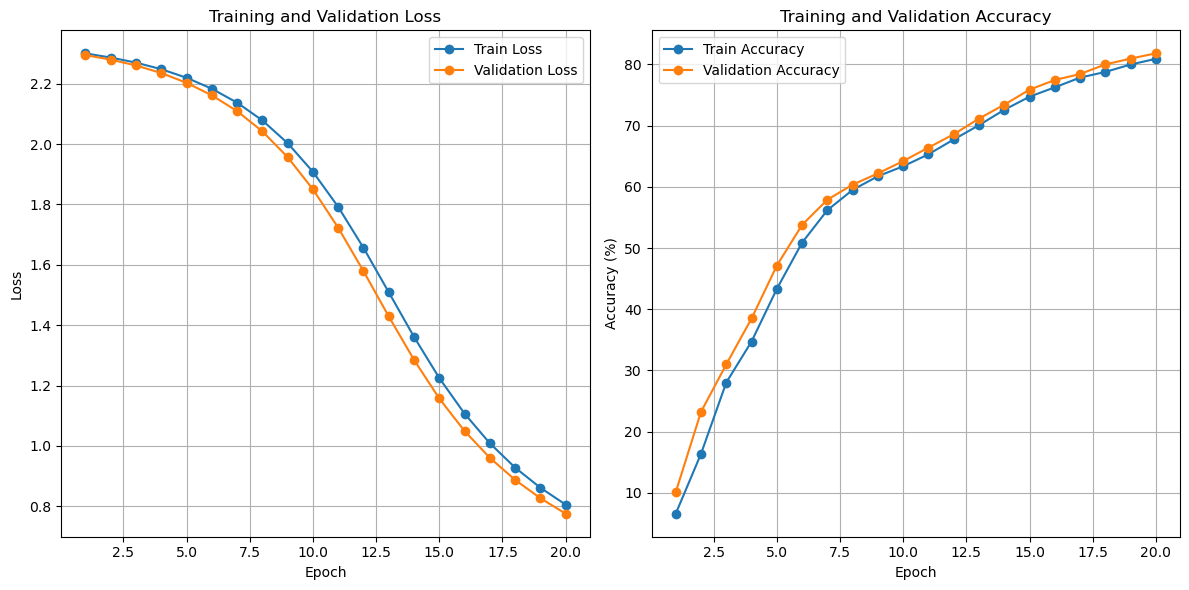

In [19]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation losses and accuracies from the history dictionary.

    Args:
        history (dict): A dictionary containing training history with keys:
                        - 'train_loss': List of training losses.
                        - 'val_loss': List of validation losses.
                        - 'train_acc': List of training accuracies.
                        - 'val_acc': List of validation accuracies.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot Losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)  # Create a subplot for losses
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)  # Create a subplot for accuracies
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

plot_training_history(history)

##### Analyzing our plots 

These plots show the training and validation loss (left) and accuracy (right) over the course of training epochs.

Both training and validation loss steadily decrease and remain closely aligned throughout the epochs. This indicates that the model is learning effectively without signs of overfitting. We also see that training and validation accuracy show consistent improvement over epochs, eventually plateauing as they converge. This suggests stable training and good generalization to unseen data.

Notice how the trend suggest that we could train for more epochs to improve the model's performance. Since this is a demo example, we will let it rest for now but feel free to experiment with the number of epochs and other hyperparameters to see how they affect the model's performance.

##### How to handle overfitting
While we don't overfit the training data in this example, it's a common problem in deep learning. Overfitting occurs when the model learns to perform well on the training data but fails to generalize to new, unseen data. This can happen when the model is too complex or when the training data is limited. Essentially, it becomes economical for the model to memorize the training data rather than learn general patterns.

Here are some common strategies to prevent overfitting:

* **Regularization**: Techniques like L1 and L2 regularization add a penalty term to the loss function, discouraging large weights and reducing model complexity. In PyTorch, we can add regularization to the optimizer using the `weight_decay` parameter, like so

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
```

* **Dropout layers**: Dropout layers randomly set a fraction of input units to zero during training, preventing the model from relying too heavily on specific neurons. We can add dropout layers to our model using `nn.Dropout`.

```python
# other layers
nn.Dropout(0.5)
# other layers
```

* **Early stopping**: Monitor the model's performance on a validation set and stop training when performance starts to degrade. This prevents the model from overfitting to the training data.


***

##### Evaluation

Now that we have trained the model, we can evaluate its performance on the test dataset. This dataset contains images that the model has never seen before, allowing us to assess how well the model generalizes to new, unseen data.

It is also common practice to do a final evaluation on the training data and validation data - as a sanity check - to ensure that the model is not overfitting to the training data.

We can use the `classification_report` function from the `sklearn.metrics` module to generate a detailed report of the model's performance on the test dataset. This report includes metrics such as precision, recall, and F1 score for each class, as well as the overall accuracy of the model.

In [20]:
import torch
from sklearn.metrics import classification_report


model.eval()  # Set model to evaluation mode

total_loss = 0.0
correct = 0
total = 0

all_labels = []  # Collect all true labels
all_predictions = []  # Collect all predicted labels

with torch.no_grad():  # Disable gradient computation
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Flatten the images
        images = images.view(images.size(0), -1)

        # Forward pass
        outputs = model(images)

        # Compute loss
        loss = criterion(outputs, labels)
        total_loss += loss.item() * images.size(0)

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        # Update accuracy metrics
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate metrics
avg_loss = total_loss / len(test_loader.dataset)
accuracy = 100 * correct / total

# Print results
print("Evaluation Results:")
print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Generate and print classification report
class_names = test_loader.dataset.classes
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


Evaluation Results:
Loss: 0.7573, Accuracy: 82.27%

Classification Report:
              precision    recall  f1-score   support

    0 - zero       0.88      0.95      0.92       980
     1 - one       0.88      0.98      0.93      1135
     2 - two       0.88      0.80      0.84      1032
   3 - three       0.74      0.83      0.78      1010
    4 - four       0.79      0.81      0.80       982
    5 - five       0.84      0.56      0.67       892
     6 - six       0.87      0.90      0.88       958
   7 - seven       0.87      0.87      0.87      1028
   8 - eight       0.74      0.77      0.76       974
    9 - nine       0.74      0.72      0.73      1009

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



##### Save/load the model

Once we have trained the model, we can save it to disk using the `torch.save()` function. This allows us to load the model later for inference or further training without having to retrain it from scratch.

In [21]:
# Save the model
torch.save(model.state_dict(), "mnist_model.pth")

In [22]:
# Load the trained model
model = MNIST_NN()  # Initialize the model architecture
model.load_state_dict(torch.load("mnist_model.pth", weights_only=True))  # Load weights into the model
model.eval()  # Set the model to evaluation mode

# Load a single image (e.g., from test_loader)
image, label = next(iter(test_loader))  # Get a batch from DataLoader
single_image = image[0].unsqueeze(0)  
single_label = label[0].item()


# Flatten the image if your model expects a flat vector (e.g., for a fully connected layer)
single_image = single_image.view(single_image.size(0), -1)  # Reshape to [1, 784] if necessary

# Make a prediction
output = model(single_image)  # Forward pass
_, predicted = torch.max(output, 1)  # Get the predicted class index

# Print the results
print(f"Predicted class: {predicted.item()}")
print(f"True class: {label[0].item()}")

Predicted class: 7
True class: 7


Congratulations! You have now built and evaluated a neural network model for image classification using the MNIST dataset. You have learned how to define a neural network architecture, load and preprocess data, train the model, and evaluate its performance. This is a significant milestone in your journey to mastering deep learning 🎉